# **Importación de datos y librerías**

In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from seaborn import heatmap
from sklearn.preprocessing import scale, LabelEncoder, quantile_transform
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Algunas constantes
numeric_att = ['Age', 'Height', 'Weight', 'Vegetable_Frecuency', 
                   'Day_Main_Meals','Water_Liters', 'Physical_Activity', 
                   'Use_Tecnology']

categorical_att = ['Gender', 'Family_History', 'Calorie_Frecuency', 
                   'Food_Between_Meals', 'Smoke', 'Calories_Control', 
                   'Drink_Alcohol', 'Transport', 'Obesity_Level']

# Carga los datos (desde un repositorio en GitHub)
url="https://raw.githubusercontent.com/paladinescamila/Parcial_1/main/data.csv"
data = pd.read_csv(url, na_values=" ?")

# Cambia los nombres de los atributos para poder ententerlos mejor
data.columns = ['Gender', 'Age', 'Height', 'Weight', 'Family_History', 
                'Calorie_Frecuency', 'Vegetable_Frecuency', 'Day_Main_Meals', 
                'Food_Between_Meals', 'Smoke', 'Water_Liters', 
                'Calories_Control', 'Physical_Activity', 'Use_Tecnology', 
                'Drink_Alcohol', 'Transport', 'Obesity_Level']
data

,Gender,Age,Height,Weight,Family_History,Calorie_Frecuency,Vegetable_Frecuency,Day_Main_Meals,Food_Between_Meals,Smoke,Water_Liters,Calories_Control,Physical_Activity,Use_Tecnology,Drink_Alcohol,Transport,Obesity_Level
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


# **Entendimiento de los datos**

In [ ]:
# Cantidad de registros y atributos
data.shape

In [ ]:
# Tipo de los atributos
data.dtypes

In [ ]:
# Medidas de centralidad y dispersión (atributos numéricos)
data.describe()

In [ ]:
# Diagrama de cajas y bigotes (atributos númericos)
plt.boxplot((data['Age'], data['Height'], data['Weight'], 
             data['Vegetable_Frecuency'],data['Day_Main_Meals'], 
             data['Water_Liters'], data['Physical_Activity'], 
             data['Use_Tecnology']))
plt.show()

In [ ]:
# Medidas de centralidad (atributos categóricos)
data.mode()

In [ ]:
# Distribución de los datos (atributos categóricos)
for i in categorical_att:
    plt.title(i)
    plt.hist(data[i])
    plt.show()

In [ ]:
# Correlación (tabla)
data.corr()

In [ ]:
# Correlación (gráfica)
heatmap(data.corr(), square=True, annot=True)

In [ ]:
# Datos faltantes por cada atributo
data.isnull().sum()

In [ ]:
# Datos atípicos de cada atributo
for i in numeric_att:
    plt.title(i)
    plt.boxplot(data[i])
    plt.show()

In [ ]:
# Cantidad de registros por nivel de obesidad
data['Obesity_Level'].value_counts()

In [ ]:
# Gráfica de la cantidad de registros por nivel de obesidad
data['Obesity_Level'].value_counts().plot(kind='bar')

In [ ]:
# Cantidad de duplicados por nivel de obesidad
levels = data.groupby(['Obesity_Level'])
for name, group in levels:
    print(name, group[group.duplicated()].count()[0])

In [ ]:
# Cantidad de registros sin valores atípicos
temp = data[numeric_att]
temp[(np.abs(stats.zscore(temp)) < 3).all(axis=1)].count()[0]

In [ ]:
# Cantidad de registros sin valores atípicos por clase
levels = data.groupby(['Obesity_Level'])
names, complete, total = [], [], []
for name, group in levels:
    numeric = group[numeric_att]
    names += [name]
    complete += [numeric[(np.abs(stats.zscore(numeric)) < 3).all(axis=1)].count()[0]]
    total += [group.count()[0]]

pd.DataFrame({'Completos': complete, 'Total':total}, index=names).plot(kind='bar')

### **Conclusiones sobre el entendimiento de los datos**
En [ScienceDirec](https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub) se encuentra una descripción de los datos, que ayudan un poco para entender qué significa cada atributo (ya que las siglas no son muy claras). Entonces, para la mejor comprensión de los atributos al usarlos en su estudio y aprendizaje se cambiaron sus nombres por los que se consideraban más claros.

En general se puede concluir lo siguiente:

- El conjunto de datos es viable, ya que no hay datos faltantes, hay pocos datos atípicos en la mayoría de los atributos y está balanceado de acuerdo con el atributo a predecir.
- La principal dificultad que tiene el conjunto de datos es que varios atributos que deberían ser categóricos son numéricos (con "datos intermedios", es decir, con valores como 2.4 en vez de 2 o 3, por ejemplo).
- No es necesario eliminar atributos, pues su correlación es muy poca.
- Los datos atípicos presentes en el conjunto de datos no representan un problema ya que permite una diversidad de los datos, por ejemplo, en cuanto a edad o cantidad de comidas principales diarias que son útiles para la construcción del modelo.
- Afortunadamente no hay valores nulos.
- En principio se podría pensar en discretizar los atributos "Day_Main_Meals" y "Vegetable_Frecuency", ya que en su descripción son discretos, pero los datos no siguen esa especificación y se desconoce el motivo, por lo tanto se mantienen, ya que restringirlos a un rango menor de posibilidades, los modelos pueden sesgarse.
- Es necesario eliminar los registros duplicados.
- Es necesario normalizar los valores de los atributos ya que hay algunos atributos (como "Weight") muy variados de los demás.
- Es necesario pasar los atributos categóricos a numéricos.
- El conjunto de datos está balanceado en los distintos valores que puede tomar el atributo a predecir.

### **Plan de ajuste de datos**
1. Normalizar los valores de los atributos "Age" y "Weight".
2. Pasar los atributos categóricos a numéricos.
3. Eliminar los registros duplicados.
4. Verificar la correlación entre los atributos para ver en qué se ha afectado al realizar las modificaciones.
5. Verificar el balance de las clases para ver si se ha afectado al eliminar los duplicados.

# **Pre-procesamiento de los datos**

In [415]:
# Paso 1: Normalizar los valores de los atributos "Age" y "Weight"
data['Age'] = scale(data['Age'])
data['Weight'] = scale(data['Weight'])

In [416]:
# Paso 2: Pasar los atributos categóricos a numéricos
categorize = data.apply(LabelEncoder().fit_transform)
for i in categorical_att:
    data[i] = categorize[i]

In [ ]:
# Paso 3: Eliminar los registros duplicados
data.drop_duplicates()

In [ ]:
# Paso 4: Verificar la correlación
data.corr()

In [ ]:
# Paso 5: Verificar el balance de las clases
data['Obesity_Level'].value_counts().plot(kind='bar')

# **Separar el conjunto de datos para entrenamiento y prueba**

In [421]:
# Separación de datos
X, y = data.drop('Obesity_Level', axis=1), data['Obesity_Level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Listas para comparar las métricas de las diferentes técnicas
precisions, recalls, fscores = [0,0,0,0], [0,0,0,0], [0,0,0,0]

# **Modelos de Clasificación**

In [ ]:
# Regresión Logística
regression_model = LogisticRegression(random_state=42).fit(X_train, y_train)
regression_predict = regression_model.predict(X_test)

In [ ]:
# K-vecinos más cercanos
best, metrics, neighbors_best = 0, [0,0,0], None
for k in range(3, 20):
    neighbors_model = neighbors.KNeighborsClassifier(k, weights='uniform').fit(X_train, y_train)
    neighbors_predict = neighbors_model.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, neighbors_predict, average='macro')
    if (precision > metrics[0] or recall > metrics[1] or fscore > metrics[2]):
        best, metrics, neighbors_best = k, [precision, recall, fscore], neighbors_predict
print('El mejor valor de k es {0} con precisión {1:.10f}, recall {2:.10f} y fscore {3:.10f}'.format(best, metrics[0], metrics[1], metrics[2]))

In [424]:
# Análisis Discriminante Lineal
linear_model = LinearDiscriminantAnalysis().fit(X_train, y_train)
linear_predict = linear_model.predict(X_test)

In [ ]:
# Análisis Discriminante Cuadrático
quadratic_model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
quadratic_predict = quadratic_model.predict(X_test)

# **Matriz de confusión**

In [ ]:
# Matriz de confusión para Regresión Logística
# print(confusion_matrix(y_test, regression_predict))
heatmap(pd.crosstab(y_test, regression_predict, rownames=['Real'], colnames=['Predicted']), annot=True)
plt.show()

In [ ]:
# Matriz de confusión para K-vecinos más cercanos
# print(confusion_matrix(y_test, neighbors_best))
heatmap(pd.crosstab(y_test, neighbors_best, rownames=['Real'], colnames=['Predicted']), annot=True)
plt.show()

In [ ]:
# Matriz de confusión para Análisis Discriminante Lineal
# print(confusion_matrix(y_test, linear_predict))
heatmap(pd.crosstab(y_test, linear_predict, rownames=['Real'], colnames=['Predicted']), annot=True)
plt.show()

In [ ]:
# Matriz de confusión para Análisis Discriminante Cuadrático
# print(confusion_matrix(y_test, quadratic_predict))
heatmap(pd.crosstab(y_test, quadratic_predict, rownames=['Real'], colnames=['Predicted']), annot=True)
plt.show()

# **Métricas de desempeño**

In [ ]:
# Métricas de desempeño para Regresión Logística
precision, recall, fscore, support = precision_recall_fscore_support(y_test, regression_predict, average='macro')
print('Precision: {0:.5f}\nRecall: {1:.5f}\nF1-Score: {2:.5f}'.format(precision, recall, fscore))
precisions[0], recalls[0], fscores[0] = precision, recall, fscore

In [ ]:
# Métricas de desempeño para K-vecinos más cercanos
precision, recall, fscore, support = precision_recall_fscore_support(y_test, neighbors_best, average='macro')
print('Precision: {0:.5f}\nRecall: {1:.5f}\nF1-Score: {2:.5f}'.format(precision, recall, fscore))
precisions[1], recalls[1], fscores[1] = precision, recall, fscore

In [ ]:
# Métricas de desempeño para Análisis Discriminante Lineal
precision, recall, fscore, support = precision_recall_fscore_support(y_test, linear_predict, average='macro')
print('Precision: {0:.5f}\nRecall: {1:.5f}\nF1-Score: {2:.5f}'.format(precision, recall, fscore))
precisions[2], recalls[2], fscores[2] = precision, recall, fscore

In [ ]:
# Métricas de desempeño para Análisis Discriminante Cuadrático
precision, recall, fscore, support = precision_recall_fscore_support(y_test, quadratic_predict, average='macro')
print('Precision: {0:.5f}\nRecall: {1:.5f}\nF1-Score: {2:.5f}'.format(precision, recall, fscore))
precisions[3], recalls[3], fscores[3] = precision, recall, fscore

# **Análisis de los resultados**
Tomando como referencia los resultados obtenidos se puede apreciar la diferencia entre las técnicas de clasificación, observando sus fortalezas y debilidades de la siguiente manera:

- **Regresión Logística.** Esta técnica obtuvo buenos resultados al aplicarla al dataset correspondiente, aunque no fue la mejor, se pudo observar que sus métricas eran altas debido a que se basa en la relación directa entre los datos de entrada y el valor de salida. Como en este dataset en particular existe una relación muy estrecha entre lo que son los datos de entrada (hábitos, peso, altura, antecedentes familiares, etc.) y los datos de salida (nivel de obesidad), esta técnica se desempeña muy bien. Por otro lado, dado que este dataset es multiclase, el término "linealmente separable" aún se desconoce para verificar bien si la técnica funciona en este sentido.

- **K-vecinos más cercanos.** La técnica es buena, ya que el dataset no es demasiado grande, y el cómputo de los k-vecinos no tiene una complejidad computacional alta. Por otro lado, ya que es una técnica de aproximación, no se garantiza que la predicción sea buena si la distancia euclidiana entre el dato a predecir y los demás, es lo suficientemente grande como para no lograr acertar en él.

- **Análisis Discriminante Lineal.** Es una buena técnica ya que no se enfoca en buscar una aproximación al valor real que se quiere predecir, sino que se encarga de que el dato que predijo es el mejor, por lo que independientemente del dataset es una técnica recomendada para obtener mejores predicciones. Sin embargo, tiene una complejidad computacional alta (debido a la gran cantidad de operaciones que demanda la técnica desde el punto de vista matemático), aunque el dataset no es muy grande sí tiene un tamaño considerable para decidir entre elegir o no la técnica.

- **Análisis Discriminante Cuadrático.** Aunque es una técnica eficaz para algunos casos, en el dataset estudiado no se obtuvo buenos resultados, ya que el valor a predecir poseía más de dos clases, esto provocó que el modelo se equivocara mucho más ya que este no está adaptado a las predicciones multiclase.

Finalmente, teniendo en cuenta las anteriores consideraciones y las métricas de desempeño, la técnica más adecuada para este conjunto de modelos en particular es el *Análisis Discriminante Lineal*, como se puede observar en la siguiente gráfica.

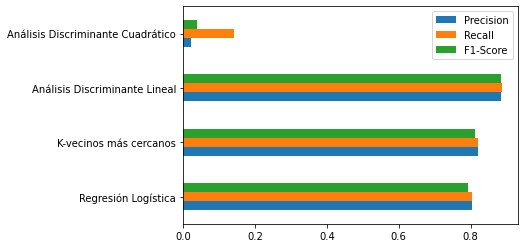

In [434]:
# Comparación de las técnicas de clasificación
techniques = ['Regresión Logística', 'K-vecinos más cercanos', 
              'Análisis Discriminante Lineal', 'Análisis Discriminante Cuadrático']
pd.DataFrame({'Precision': precisions, 'Recall': recalls, 'F1-Score': fscores}, index=techniques).plot(kind='barh')